In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context('paper')

import mne
from autoreject import LocalAutoRejectCV
mne.set_log_level('ERROR')

import pandas as pd
import scipy.stats as stats
from os import listdir
import numpy as np
from scipy.stats import ttest_rel as t_rel 
from collections import Counter


df = pd.read_csv('~/conincon_data/lookUp.csv') # load csv with sentence info
event_ids = {"con/hc":201, "con/lc":200, "inc/lc":210, "inc/hc":211}

loc_files="~/conincon_data/files/" # location of all files
template = "{}-epo.fif" # template to load epochs

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
bads = ["VLA21", # not a native speaker of German
        "GMA05","RAC22","PBT16","HHA01","BSN17"]

In [3]:
names = list({fname.split("-")[0]  # list of participant IDs
              for fname in listdir(loc_files) 
              if "on_ica" in fname and fname.split("-")[0] not in bads
             })

In [4]:
def get_epochs(name):
    '''
    loads the epoched data for participant (name)
    '''
    
    epoch = mne.read_epochs(loc_epochs+template.format(name))
    return epoch

In [5]:
# get ERPs for conditions by subject
erps = dict()
for name in names:
    erps[name] = dict()
    epoch = get_epochs(name).drop_channels(["SO1", "SO2", "FP1", "FP2"])
    for cond in event_ids:
        erps[name][cond] = epoch[cond].average()

In [6]:
# average condition based ERPs for plotting difference wave
grands = {cond:mne.combine_evoked([erps[name][cond] for name in names], weights='equal')
          for cond in list(event_ids.keys())}

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


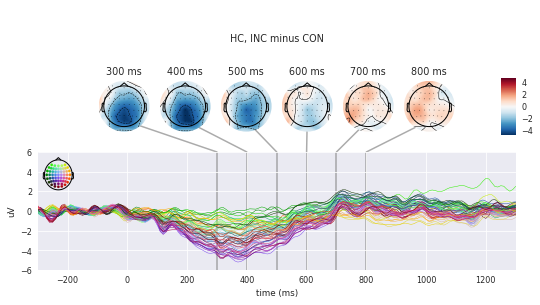

In [7]:
sns.set_context("paper")
sns.set_style("darkgrid")
# butterfly plor of incongruent-congruent trials
plt1 = mne.combine_evoked([grands["inc/hc"], grands["con/hc"],
                   ], weights=[1, -1]).plot_joint([.3, .4,0.5,.6, .7,.8], title="HC, INC minus CON", 
                                                  ts_args={"ylim":{"eeg":[-6, 6]}});

In [8]:
plt1.savefig(loc_files+'butters.pdf')

In [9]:
# average ERPs for for HC sentences
erp_hc = dict()
for cond in event_ids:
    if "hc" in cond:
        erp_hc[cond.split("/")[0]] = [erps[name][cond] for name in names]

erp = erps[name][cond]  # need this one for channel picking

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


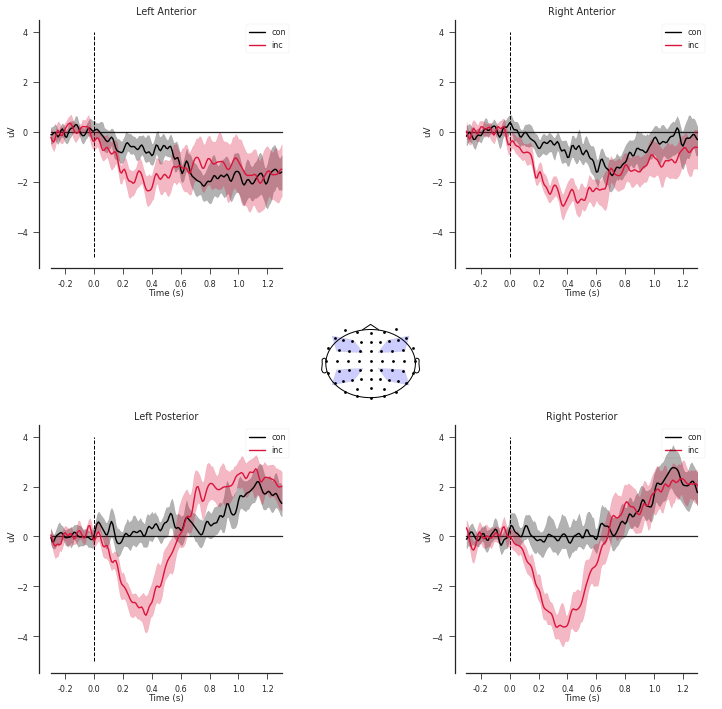

In [10]:
# plotting averaged activity over ROIs (Left anterior, right anterior, left posterior, right posterior)

from matplotlib import gridspec
from mne.datasets import testing
from mne.channels.layout import _find_topomap_coords
from scipy.spatial import ConvexHull
from matplotlib.patches import Polygon
from mne.viz.topomap import _draw_outlines, _check_outlines
from matplotlib.patches import ConnectionPatch

sns.set_style("ticks", {"xtick.major.size": 6, "ytick.major.size": 6})


f = plt.figure()
f.set_size_inches(12, 12)

gs = gridspec.GridSpec(5, 5)
ax1 = plt.subplot(gs[0:2, 0:2])
ax2 = plt.subplot(gs[0:2, 3:])
ax3 = plt.subplot(gs[3:5, :2])
ax4 = plt.subplot(gs[3:5,3:5])
ax_ = plt.subplot(gs[2, 2])

def plot_hull(points, ax):
    # outlines ROIs in sensor map
    hull = ConvexHull(points)
    cent = np.mean(points, 0)
    pts = []
    for pt in points[hull.simplices]:
        pts.append(pt[0].tolist())
        pts.append(pt[1].tolist())

    pts.sort(key=lambda p: np.arctan2(p[1] - cent[1],
                                    p[0] - cent[0]))
    pts = pts[0::2]  # Deleting duplicates
    pts.insert(len(pts), pts[0])
    k = 1.25
    color = 'blue'
    poly = Polygon(k*(np.array(pts)- cent) + cent,
                   edgecolor="k",
                   facecolor=color, alpha=0.2)
    poly.set_capstyle('round')
    ax.add_patch(poly)

evoked = erp_hc["con"][0]

pos_xy = np.asarray(_find_topomap_coords(evoked.info, range(len(evoked.ch_names)))) # get channel coordinates
pos_x, pos_y = pos_xy.T

# define rois
roi_names = {"Left Frontal":['F3', 'F5', 'FC3', 'F7', 'FC1', 'FC5'],
       "Right Frontal": ['F4', 'FC4', 'F6', 'F8', 'FC2', 'FC6'],
                         'Left Parietal': ['CP1', 'CP3', 'P5', 'CP5', 'P3', 'P7'],
                         'Right Parietal': ['CP2', 'P6', 'CP4', 'CP6', 'P4', 'P8']}
roi_picks = {k:[evoked.ch_names.index(ch) for ch in v] for k, v in roi_names.items()}

outlines = "skirt"
pos, outlines = _check_outlines(pos_xy, outlines)

_draw_outlines(ax_, outlines);
x_, y_ = pos.T
ax_.plot(x_, y_, 'k.')
ax_.axis("off")

for name, roi in roi_picks.items():
    pts = np.array(pos)[roi]
    plot_hull(pts, ax_)
    x, y = pts.mean(0)
    ax_.plot(x, y, 0, 1)

vmax = evoked.data.max() / .000001
vmin = evoked.data.min() / .000001

ax_dict = {"Left Frontal": ax1, "Right Frontal": ax2,
           "Left Parietal": ax3, "Right Parietal": ax4}
edge_dict = {"Left": .80, "Right": .20, "Frontal": -.25, "Parietal": 1.15}

roin = {"Left Frontal": "Left Anterior", "Right Frontal": 'Right Anterior',
           "Left Parietal": "Left Posterior", "Right Parietal": "Right Posterior"}

places = {"Left Frontal": "A", "Right Frontal": "B",
           "Left Parietal": "C", "Right Parietal": "D"}

for name, roi in roi_picks.items(): 
    # plots individual ERP plots for condition averaged in each ROI 
    # with bootstrapped 95% confidence intervals
    place = places[name]    
    ax2_ = ax_dict[name]
    rn = roin[name]
    mne.viz.plot_compare_evokeds(erp_hc, axes=ax2_,colors=["k", "crimson"], show=False, linestyles=["-", "--"], 
                                 truncate_yaxis=False,truncate_xaxis=False,
                                 show_sensors=False,picks=roi, ylim={"eeg":(-5, 4)}, title="{}".format(rn))
    ax2_.tick_params("Arial", labelsize=10)

In [72]:
f.savefig(loc_files+"ERPs.pdf")

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


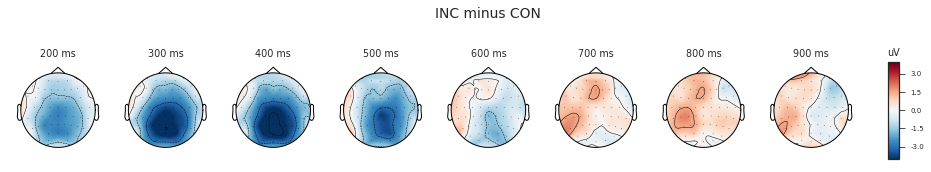

In [11]:
# plot topo maps
pl1 = mne.combine_evoked([grands["inc/hc"], grands["con/hc"],
                   ], weights=[1, -1]).plot_topomap(times=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                                                    title="INC minus CON", vmin=-4, vmax=4);


In [82]:
pl1.savefig(loc_files+"topomaps-bw.pdf")

/data/home1/eheikel/tools/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


In [12]:
def big_data(names):
    '''
    Creates a big data frame for all participants of epoched data by electrodes over time
    
        names: a list of names corresponding to participants
    '''
    
    # list of epochs looking only at HC
    ep = {name: get_epochs(name)["hc"] for name in names}

    # create a massive dataframe for all channel and data for univariate analysis
    dfs = []
    ns = []
    for ii, name in enumerate(names):
        #ep = epoch = mne.read_epochs(template.format(name))
        df_ = ep[name].to_data_frame()
        df_ = df_.reset_index(level=1, drop=True)
        x = []
        for k in ep[names[0]].event_id.keys():
            d_t = df_.loc[k] 
            for i, m in d_t.iterrows():
                m["subj"] = ii
                m["cond"] = k.split("/")[0]
                m["times"] = i
                x.append(m)
        df_t = pd.DataFrame(x)
        df_ = pd.melt(df_t, id_vars=["subj","times","cond"],
                      var_name="electrode", value_name="uV") 

        dfs.append(df_)
        ns.append(name)
    df2 = pd.concat(dfs)
    
    return df2

In [ ]:
# save the dataframe as a csv to avoid having to do this over and over
# as it takes a long time to calculate
df2 = big_data(names)
df2.to_csv(loc_files+"big_data.csv") 

In [7]:
df2 = pd.read_csv(loc_files+"big_data.csv") # to load the csv if saved

In [35]:
def select_times(df, tmin, tmax):
    # average over time window of interest for all electrodes and subjects
    dft = df.query("{} < times < {}".format(tmin, tmax)).groupby(["subj", "cond",
                                                                      "electrode", 
                                                                      ]).mean().reset_index()
    return dft

def select_elecs(dataframe):
    # identify electrodes in ROIs
    
    ROIs = {'AL': ['F3', 'F5', 'FC3', 'F7', 'FC1', 'FC5'],
            'AR': ['F4', 'FC4', 'F6', 'F8', 'FC2', 'FC6'],
            'PL': ['CP1', 'CP3', 'P5', 'CP5', 'P3', 'P7'],
            'PR': ['CP2', 'P6', 'CP4', 'CP6', 'P4', 'P8']}
    
    dft = pd.DataFrame()
    for roi in ROIs:
        temp = dataframe[dataframe['electrode'].isin(ROIs[roi])].copy()
        r = []
        for ii, x in temp.iterrows():
            r.append(roi)
        temp["elecs"] = r 
        dft=dft.append(temp)
    return dft

def average_over_rois(df_):
    # average over region of interest
    # don't have to do this if electrodes are in the error term
    cs = ["con", "inc"]
    df = pd.DataFrame()
    rois, subj, condition, hemi, frontal, dep_v = [],[],[],[],[], []
    for ii, s in enumerate(Counter(df_.subj).keys()):
        d1 = df_.query("subj=={}".format(s))
        for roi in Counter(d1.elecs):
            x = d1.query("elecs=='{}'".format(roi))
            for c in cs:
                uV = x.query("cond=='{}'".format(c)).uV.mean()
                rois.append(roi), subj.append(s), condition.append(c) 
                hemi.append(list(x.hemi)[0]), frontal.append(list(x.frontal)[0]), dep_v.append(uV)
    df["subj"] = subj
    df["condition"] = condition
    df["elecs"] = rois
    df["hemi"] = hemi
    df["frontal"] = frontal
    df["uV"] = dep_v
    
    return df

def identify_position(df):  
    # average over rois and identify whether frontal/posterior and left/right
    df=pd.melt(select_elecs(df), id_vars=["subj", "cond", 
                                          "times", "elecs"], 
           value_vars="uV", value_name="uV").drop("variable", 1)
    
    hemi, anti = [], []
    for ii, m in df.iterrows():
        el = m.elecs
        a, h = el[0], el[1]
        anti.append(("frontal" if a=="A" else "posterior"))
        hemi.append(("left" if h=="L" else "right")) 
        
    df["hemi"] = hemi
    df["frontal"] = anti
    
    df = average_over_rois(df)
    return df


In [40]:
# define time windows of interest
n4_times =  [300, 500]
p6_times = [600, 800]

# create data frames for averaged ROIs and time windows for subjects
n4 = identify_position(select_times(df2, n4_times[0], n4_times[1])) # N400 time window
p6 = identify_position(select_times(df2, p6_times[0], p6_times[1])) # P600 time window

# save DataFrame for univariate statistics
n4.to_csv(savsP+"n4-data20z-{}-{}.csv".format(str(n4_times[0]), str(n4_times[1])))
p6.to_csv(savsP+"p6-data20hz-{}-{}.csv".format(str(p6_times[0]), str(p6_times[1])))

# ANOVA results

###  N400 repeated measures ANOVA 2x2x2
 - main effect of congruency
 - interaction with congruency and anteriority



In [49]:
# paired ttest in anterior region
t_rel(incfr, confr)

Ttest_relResult(statistic=-4.7003621688273336, pvalue=3.208278004787402e-05)

In [52]:
# average difference in posterior region congruent-incongruent (i.e. relatively negative for incongruent)
np.mean(meansp), np.std(meansp)

(2.9963998283421374, 2.2437226169968651)

In [53]:
# paired ttest in posterior region
t_rel(incp, conp)

Ttest_relResult(statistic=-8.3399395222230801, pvalue=3.3507878557474232e-10)

In [55]:
meansl = []
conl, incl = [], []
meansr = []
conr, incr = [], []
for s in Counter(p6.subj.values):
    dft = p6.query("subj=={}".format(s))
    il = dft.query("hemi=='left' & condition=='inc'").uV.mean()
    cl =dft.query("hemi=='left' & condition=='con'").uV.mean()
    conl.append(cl)
    incl.append(il)
    meansl.append(cl-il)
    
    ir = dft.query("hemi=='right' & condition=='inc'").uV.mean()
    cr =dft.query("hemi=='right' & condition=='con'").uV.mean()
    conr.append(cr)
    incr.append(ir)
    meansr.append(cr-ir)

In [56]:
# average difference in left hemishpere  congruent-incongruent (i.e. relatively more positive for incongruent)
np.mean(meansl), np.std(meansl)

(-0.77312726234316964, 2.3672276724703756)

In [58]:
# paired ttest in left hemi
t_rel(incl, conl)

Ttest_relResult(statistic=2.0395918237985828, pvalue=0.048206575933645204)

In [59]:
# average difference in right hemishpere  congruent-incongruent (i.e. relatively more negative for incongruent)
np.mean(meansr), np.std(meansr)

(0.22777225069265133, 2.2514068408407382)

In [60]:
# paired ttest in right hemi
t_rel(incr, conr)

Ttest_relResult(statistic=-0.63179929271918178, pvalue=0.53120431117398481)